In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import GaussianNB 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import string
from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [94]:
data=pd.read_csv('./Train.csv')
data_test=pd.read_csv('./Test.csv')
le = LabelEncoder()

In [110]:
data['label'] = le.fit_transform(data['label'])

In [12]:
sw = set(stopwords.words('english'))
ps = PorterStemmer()

In [29]:
def clean_text(sample):
    sample = sample.lower()
    sample = sample.replace("<br /><br />"," ")
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [ps.stem(s) for s in sample if s not in sw]
    sample = " ".join(sample)
    
    return sample

In [38]:
clean_text(data['review'][11])

'robert jordan televis star robert jordan like thing orderli time properli execut world children seen heard would mr jordan want becom master rambuncti band boy scout rate staff figur learn interact youth inclin watch show cours watch jordan cope compris fun like mr belveder mr belveder goe colleg one sure pleas anyon interest obtain copi film pleas write iamas yahoo com'

In [39]:
data['clean_review'] = data['review'].apply(clean_text)

In [43]:
corpus = data['clean_review'].values

In [51]:
cv = CountVectorizer(max_df=0.5,max_features=50000)

In [99]:
X = cv.fit_transform(corpus)

In [100]:
X.shape

(40000, 50000)

In [101]:
tfidf = TfidfTransformer()

In [102]:
X = tfidf.fit_transform(X)

In [131]:
from keras.layers import Dense
from keras import Model
from keras.models import Sequential

In [132]:
model = Sequential()
model.add(Dense(16,activation="relu",input_shape=(X.shape[1],)))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                800016    
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 800,305
Trainable params: 800,305
Non-trainable params: 0
_________________________________________________________________


In [133]:
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])

In [134]:
y = data['label'].values

In [135]:
x_val = X[:5000]
x_train = X[5000:]

y_val = y[:5000]
y_train = y[5000:]

In [136]:
x_train.shape,y_train.shape

((35000, 50000), (35000,))

In [263]:
hist = model.fit(X,y,batch_size=128,epochs=2,validation_data=(x_val,y_val))

Train on 40000 samples, validate on 5000 samples
Epoch 1/2
40000/40000 [==============================] - 20s 506us/step - loss: 0.0750 - accuracy: 0.9747 - val_loss: 0.1280 - val_accuracy: 0.9578
Epoch 2/2
40000/40000 [==============================] - 20s 505us/step - loss: 0.0699 - accuracy: 0.9769 - val_loss: 0.1141 - val_accuracy: 0.9622


In [264]:
result = hist.history

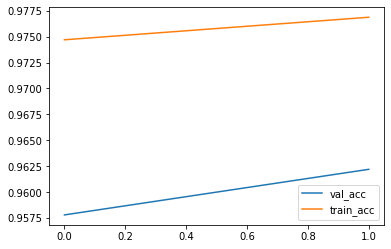

In [265]:
plt.plot(result['val_accuracy'],label='val_acc')
plt.plot(result['accuracy'],label='train_acc')
plt.legend()
plt.show()

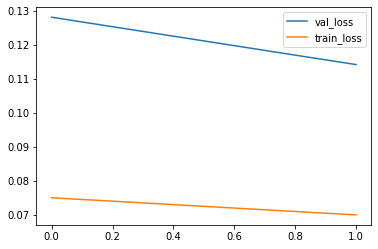

In [266]:
plt.plot(result['val_loss'],label='val_loss')
plt.plot(result['loss'],label='train_loss')
plt.legend()
plt.show()

In [267]:
model.evaluate(x_val,y_val)

5000/5000 [==============================] - 2s 421us/step


[0.11411702794134616, 0.9621999859809875]

In [268]:
data_test['review'] = data_test['review'].apply(clean_text)

In [269]:
x_test = data_test['review'].values

In [270]:
x_test = cv.transform(x_test)

In [271]:
x_test.shape

(10000, 50000)

In [272]:
x_test = tfidf.fit_transform(x_test)

In [273]:
x_test.shape

(10000, 50000)

In [274]:
y_pred = model.predict(x_test)

In [275]:
y_pred.shape

(10000, 1)

In [276]:
y_pred[y_pred>=0.5] = 1

In [277]:
y_pred = y_pred.astype('int')

In [278]:
change = {0:'neg',1:'pos'}

In [279]:
y_final = [change[n[0]] for n in y_pred]
ids = np.arange(10000)

In [280]:
final = np.stack((ids,y_final),axis=1)

In [281]:
df = pd.DataFrame(final,columns=['Id','label'])

In [282]:
df.to_csv("submission.csv",index=False)